In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning import *

# Setup
---

In [7]:

#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1, sym2 = prices.columns
S1 = prices[sym1]
S2 = prices[sym2]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

#Drop NaN values from zscore_series
zscore_series = zscore_series.dropna()

#Esnure prices and zscore_series are aligned after dropping NaN values in the zscore_series
prices = prices.loc[zscore_series.index]


Computing spread series and beta series...


# Train agent
---

In [ ]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(0.5, 2.5), (1.0, 3.0), (1.5, 4.0), (2.0, 4.5), (2.5, 5.0), (3.0, 5.5)]
# Training parameters
F, T = 200, 100

online_net, replay_buffer,epoch_loss_history, reward_history = train_dqn(zscore_series, 
                                                                   prices, 
                                                                   entry_stop_pairs, 
                                                                   F, 
                                                                   T, 
                                                                   num_epochs=600,
                                                                   batch_size=32,
                                                                   gamma = 0.99,
                                                                   lr = 0.001,
                                                                   epsilon_start = 1,
                                                                   epsilon_end = 0.01,
                                                                   epsilon_decay = 0.995,
                                                                   replay_capacity = 1000,
                                                                   target_update_freq = 5,
                                                                   hidden_dim = 64,                                           
                                                                    )

Training DQN agent...
Epoch 01 | AvgReward: 244.51 | Epsilon: 0.995
Epoch 02 | AvgReward: 301.40 | Epsilon: 0.990
Epoch 03 | AvgReward: 270.46 | Epsilon: 0.985
Epoch 04 | AvgReward: 296.41 | Epsilon: 0.980
Epoch 05 | AvgReward: 259.48 | Epsilon: 0.975
Epoch 06 | AvgReward: 278.44 | Epsilon: 0.970
Epoch 07 | AvgReward: 268.46 | Epsilon: 0.966
Epoch 08 | AvgReward: 251.50 | Epsilon: 0.961
Epoch 09 | AvgReward: 262.48 | Epsilon: 0.956
Epoch 10 | AvgReward: 298.40 | Epsilon: 0.951
Epoch 11 | AvgReward: 318.36 | Epsilon: 0.946
Epoch 12 | AvgReward: 225.55 | Epsilon: 0.942
Epoch 13 | AvgReward: 301.40 | Epsilon: 0.937
Epoch 14 | AvgReward: 245.51 | Epsilon: 0.932
Epoch 15 | AvgReward: 302.40 | Epsilon: 0.928
Epoch 16 | AvgReward: 297.41 | Epsilon: 0.923
Epoch 17 | AvgReward: 291.42 | Epsilon: 0.918
Epoch 18 | AvgReward: 313.37 | Epsilon: 0.914
Epoch 19 | AvgReward: 292.42 | Epsilon: 0.909
Epoch 20 | AvgReward: 307.39 | Epsilon: 0.905
Epoch 21 | AvgReward: 352.30 | Epsilon: 0.900
Epoch 22 | A

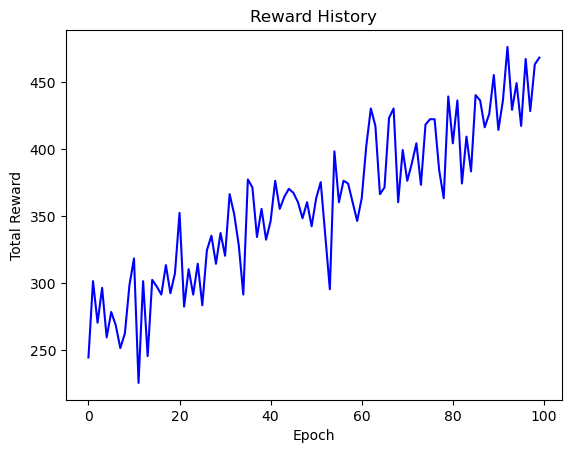

In [9]:
plt.plot(reward_history, color = 'blue')
plt.title('Reward History')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.show()

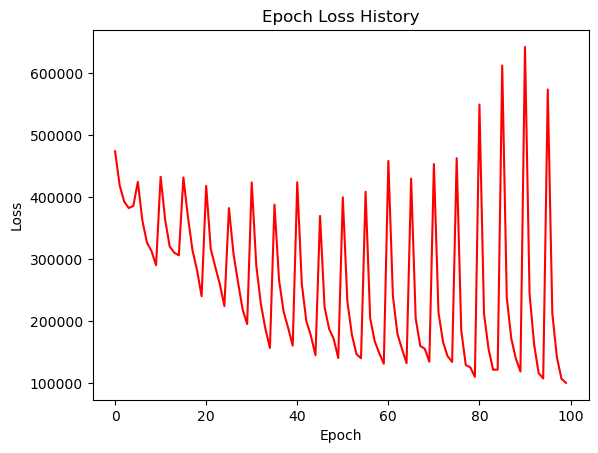

In [10]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Why the “sawtooth” spikes in the loss plot?

Those spikes are normal for two reasons:

    Variable number of updates per epoch: early on, you quickly fill the replay buffer and do many minibatch updates; later epochs may have fewer new transitions, so the average loss per epoch can jump around.

    Target-network syncs: whenever you copy the online net into the target net (every few epochs), you briefly raise the bootstrap targets, which can cause a transient bump in TD‐error before it falls again.